## Импорты

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy


## Задание 2


Посчитайте daily returns r_i = (P_(i+1) - P_i) / P_i , где i -день, и i + 1 –след. день

Посчитайте статистики распределения return-ов.
	
Для каждой акции:
	
    - Оцените, пожалуйста, схожесть полученного распределения дневных returns и одного из известных распределений – например, Gaussian, Student-t с n степенями свободы и т.д. Используйте визуальные и статистические критерии.
	- Распределение доходностей стационарно по времени? 
	- Есть ли взаимосвязь между прошлыми и будущими значениями временного ряда для отдельно выбранной акции? Если да, то значима ли она (для 1 акции)?

Есть ли интересные взаимосвязи между return-ами  различных инструментов в один и тот же период по времени? (Предположение: поиск корреляции, Granger causality, PCA decomposition of returns)

In [3]:
# Загружаем данные

facebook = pd.read_csv('data/facebook.csv')

In [4]:
def data_preparation(df):
    """Подготовка данных для анализа:
       индексы - даты, колонка - закрытие торгов
       данные за 10 лет"""
    
    df = df.rename(columns={'4. close':'close', 'Unnamed: 0':'date'})
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['date']>'2012-08-23'] # по 23 - чтоб потом удалить одну строку
    df = df.set_index(pd.DatetimeIndex(df['date']))
    df = df.sort_index() 
    
    return df[['close']]   


In [5]:
facebook = data_preparation(facebook)

In [6]:
facebook['close_next'] = facebook['close'].shift(-1)
facebook = facebook.dropna(axis=0)
facebook['daily_returns'] = (facebook['close_next'] - facebook['close'])/facebook['close']
facebook

,close,close_next,daily_returns
date,,,
2012-08-24,19.4090,19.1500,-0.013344
2012-08-27,19.1500,19.3400,0.009922
2012-08-28,19.3400,19.1000,-0.012410
2012-08-29,19.1000,19.0885,-0.000602
2012-08-30,19.0885,18.0580,-0.053985
...,...,...,...
2022-08-19,167.9600,163.0500,-0.029233
2022-08-22,163.0500,161.1100,-0.011898
2022-08-23,161.1100,163.2600,0.013345


In [7]:
# Статистические показатели

facebook['daily_returns'].describe()

count    2517.000000
mean        0.001127
std         0.023891
min        -0.263901
25%        -0.009615
50%         0.001056
75%         0.012539
max         0.296077
Name: daily_returns, dtype: float64

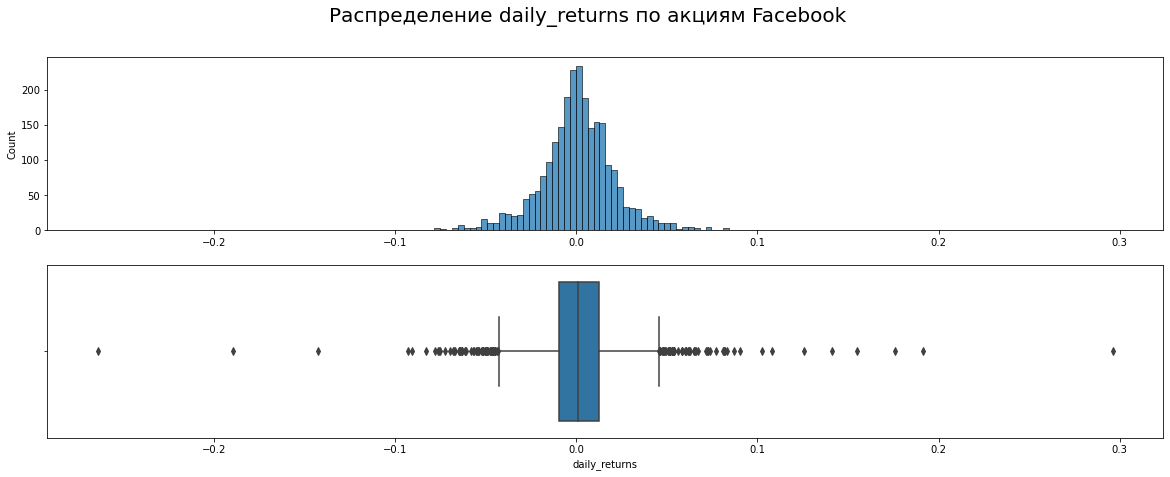

In [8]:
fig, ax = plt.subplots(2,1, figsize=(20,7))
fig.suptitle('Распределение daily_returns по акциям Facebook', fontsize=20)
sns.histplot(x=facebook['daily_returns'], ax=ax[0])
ax[0].set_xlabel('')
sns.boxplot(x=facebook['daily_returns'], ax=ax[1])
plt.show()

**Проверна на нормальное гаусовское распределение**

Визуально распределение похоже на нормальное (гаусовское). Но нужно проверить.

**Критерии нормального распределения:**
     
     - распределение симетрично и имеет форму колокола.
     - среднее значение (0.001127) и медиана (0.001056) - совпадают.
     - В пределах одного стандартного отклонения в обе стороны лежат 68.2% всех данных, в пределах двух - 95,5%, в пределах трех - 99,7% - это надо проверять:

In [9]:
m = facebook['daily_returns'].mean()
s = facebook['daily_returns'].std()
min_1s = m-s
max_1s = m+s
print('Среднее %.3f, станд. откл. %.3f,  сред-1стд %.3f,  сред+1стд %.3f' %(m, s, min_1s, max_1s))
facebook[(facebook['daily_returns']>min_1s) & (facebook['daily_returns']<max_1s)][['daily_returns']].agg(['min', 'max', 'count'])

Среднее 0.001, станд. откл. 0.024,  сред-1стд -0.023,  сред+1стд 0.025


,daily_returns
min,-0.022748
max,0.024978
count,2029.000000


In [10]:
# Процент наблюдений, содержащийся в пределах одного стандартного отклонения 
# у нас 81%  наблюдений 

2029/2517

0.8061183949145808

Проведем стат тесты:

In [11]:
print('тест Шапиро-Уилк')
stat, p = scipy.stats.shapiro(facebook['daily_returns']) 
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

тест Шапиро-Уилк
Statistics=0.869, p-value=0.000
Отклонить гипотезу о нормальности


In [12]:
print('Критерий согласия Пирсона')
stat, p = scipy.stats.normaltest(facebook['daily_returns']) 
print('Statistics=%.3f, p-value=%.3f' % (stat, p)) 
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Критерий согласия Пирсона
Statistics=757.547, p-value=0.000
Отклонить гипотезу о нормальности


Вывод: Данное распределение по тесстам не является нормальным.

**Проверка на стационарность**

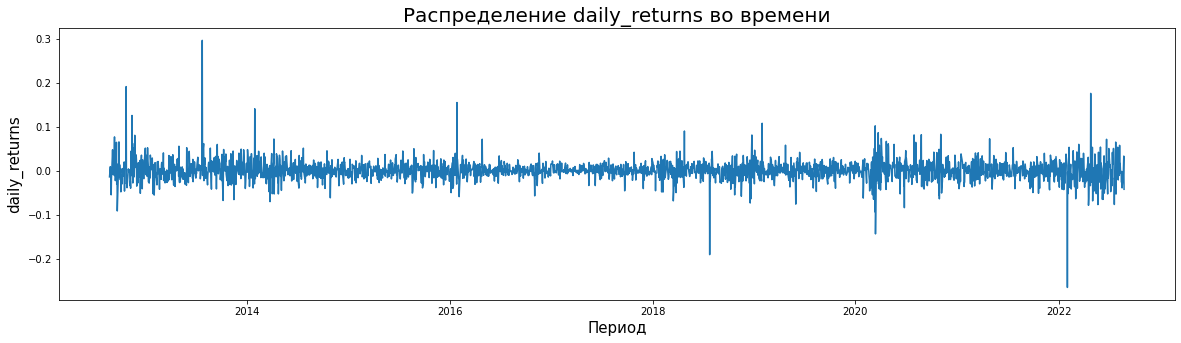

In [13]:
plt.figure(figsize=(20,5))
plt.title('Распределение daily_returns во времени', fontsize=20)
plt.plot(facebook['daily_returns'])
plt.xlabel('Период', fontsize=15)
plt.ylabel('daily_returns', fontsize=15)
plt.show()

In [14]:
print('Тест Дикки-Фуллера')
test = sm.tsa.adfuller(facebook['daily_returns'])
print('p-value: %.3f' % (test[1]))
if test[1]<0.05:
    print('ряд стационарный')
else:
    print('ряд не стационарный')

Тест Дикки-Фуллера
p-value: 0.000
ряд стационарный


По тесту и зрительно ряд выглядит стационарным. Имеются несколько выбивающихся значении. 

**Есть ли взаимосвязь между прошлыми и будущими значениями временного ряда для отдельно выбранной акции? Если да, то значима ли она (для 1 акции)?**

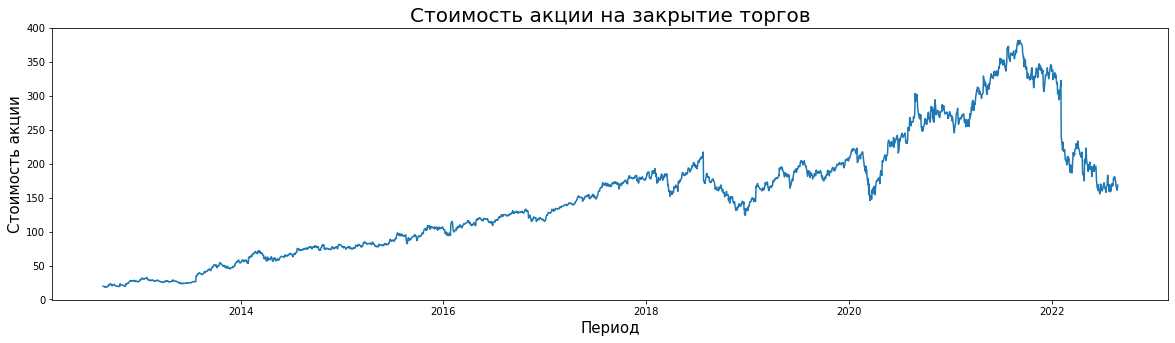

In [15]:
plt.figure(figsize=(20,5))
plt.title('Стоимость акции на закрытие торгов', fontsize=20)
plt.plot(facebook['close'])
plt.xlabel('Период', fontsize=15)
plt.ylabel('Стоимость акции', fontsize=15)
plt.show()

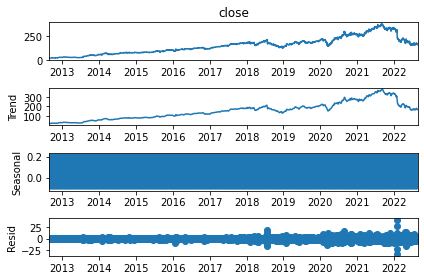

In [16]:
df_for_decomp = facebook['close'].resample('d').ffill()
decompposition = seasonal_decompose(df_for_decomp, model='additive')
decompposition.plot()
plt.show()

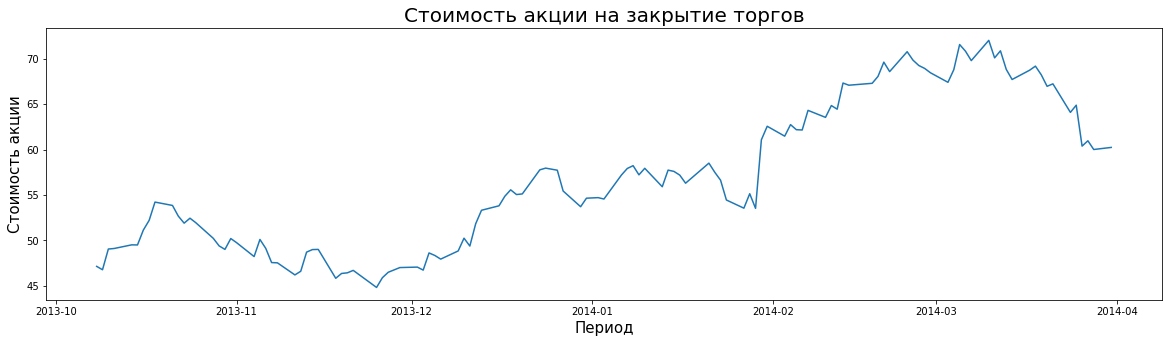

In [21]:
plt.figure(figsize=(20,5))
plt.title('Стоимость акции на закрытие торгов', fontsize=20)
plt.plot(facebook['close'].iloc[280:400])
plt.xlabel('Период', fontsize=15)
plt.ylabel('Стоимость акции', fontsize=15)
plt.show()

<Figure size 1440x504 with 0 Axes>

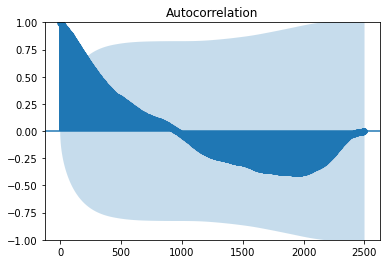

In [17]:
plt.figure(figsize=(20,7))
sm.graphics.tsa.plot_acf(facebook['close'].squeeze(), lags=2500)
plt.show()

<Figure size 1440x504 with 0 Axes>

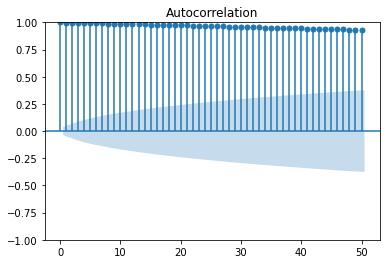

In [19]:
plt.figure(figsize=(20,7))
sm.graphics.tsa.plot_acf(facebook['close'].squeeze(), lags=50)
plt.show()

Не знаю как проверить есть связь или нет. Есть тренд, есть корреляционная зависимость, особенно в начале до 2018 года. Дальше уже стоимость акицй вебет себя инраючи.

In [27]:
facebook.drop(['close_next', 'close'], axis=1).to_csv('data/return_facebook.csv')